# Import Library

In [1]:
# CELL 1
import os

# This line MUST be executed before TensorFlow is imported for the first time.
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import tensorflow as tf

# Now, this check will correctly show that no GPUs are visible.
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

c:\Users\sinas\anaconda3\envs\tf_GPU\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Available GPUs: []


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Input, Dropout, LSTM, Conv1D, BatchNormalization, LeakyReLU, GlobalAveragePooling1D, Activation,LayerNormalization,Bidirectional,ReLU
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit 
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras import regularizers

print(tf.config.list_physical_devices())


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


# Import Data

In [3]:
Train_Data = np.genfromtxt('FordA_TRAIN.txt')
Test_Data = np.genfromtxt('FordA_TEST.txt')

Train_DF = pd.DataFrame(Train_Data)
Test_DF = pd.DataFrame(Test_Data)

In [4]:
print('Number of timestep for each training sample :' , Train_DF.shape[1]-1)
print('Number of timestep for each test sample :' , Test_DF.shape[1]-1)

print('Number of training samples :' , Train_DF.shape[0])
print('Number of test samples :' , Test_DF.shape[0])

Number of timestep for each training sample : 500
Number of timestep for each test sample : 500
Number of training samples : 3601
Number of test samples : 1320


In [5]:
x_train = Train_DF.drop(0, axis=1)
x_test = Test_DF.drop(0, axis=1)

y_train = Train_DF[0].map({-1:0,1:1})
y_test = Test_DF[0].map({-1:0,1:1})

In [6]:
x_train.head(3)

,1,2,3,4,5,6,7,8,9,10,...,491,492,493,494,495,496,497,498,499,500
0,-0.797172,-0.664392,-0.373015,0.040815,0.526936,0.984288,1.353120,1.578108,1.659251,1.640809,...,1.120756,0.722417,0.362068,0.092083,-0.081268,-0.212573,-0.391456,-0.664392,-1.073796,-1.564343
1,0.804855,0.634629,0.373474,0.038343,-0.340988,-0.740860,-1.109667,-1.395357,-1.570192,-1.619951,...,0.386403,0.049213,-0.258138,-0.510583,-0.683647,-0.773817,-0.785255,-0.714885,-0.560443,-0.319086
2,0.727985,0.111284,-0.499124,-1.068629,-1.578351,-1.990534,-2.302031,-2.503403,-2.585211,-2.550600,...,0.394463,0.463685,0.507735,0.517174,0.504588,0.476270,0.438513,0.394463,0.339400,0.255391


In [7]:
x_test.head(3)

,1,2,3,4,5,6,7,8,9,10,...,491,492,493,494,495,496,497,498,499,500
0,-0.140402,0.171641,0.302044,0.232804,0.033853,-0.224183,-0.469987,-0.645396,-0.617700,-0.367280,...,-0.319966,0.390903,0.974831,1.258717,1.143316,0.647092,-0.049582,-0.690402,-0.976596,-0.794263
1,0.334038,0.322253,0.453844,0.671852,0.887897,1.020469,1.059750,1.030290,0.950746,0.858436,...,0.435186,-0.346502,-0.924912,-1.208716,-1.247996,-1.139974,-1.041772,-1.041772,-1.159614,-1.375659
2,0.716686,0.744367,0.725913,0.661325,0.555217,0.413585,0.246580,0.065273,-0.121109,-0.301032,...,3.171020,2.276019,1.219548,0.081881,-1.050250,-2.092881,-2.983269,-3.675281,-4.136622,-4.339612


In [8]:
y_train

0       0
1       1
2       0
3       0
4       0
       ..
3596    0
3597    1
3598    0
3599    1
3600    0
Name: 0, Length: 3601, dtype: int64

In [9]:
y_test

0       0
1       0
2       0
3       1
4       0
       ..
1315    0
1316    1
1317    1
1318    1
1319    1
Name: 0, Length: 1320, dtype: int64

In [10]:
x_train = x_train.values.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.values.reshape((x_test.shape[0], x_test.shape[1], 1))

print('Train (Samples,Timesteps,features) : ', x_train.shape)
print('Test (Samples,Timesteps,features) : ', x_test.shape)

Train (Samples,Timesteps,features) :  (3601, 500, 1)
Test (Samples,Timesteps,features) :  (1320, 500, 1)


# Handling missing value

In [11]:
print('Number of feature with Nan valus in Training Data:',sum(Train_DF.isnull().sum() > 0))
print('Number of feature with Nan valus in Test Data:',sum(Test_DF.isnull().sum() > 0))

Number of feature with Nan valus in Training Data: 0
Number of feature with Nan valus in Test Data: 0


In [12]:
# Check for Duplicated Data
print('Number of duplicated data in Training Data:',sum(Train_DF.isnull().sum() > 0))
print('Number of duplicated data in Test Data:',sum(Test_DF.isnull().sum() > 0))

Number of duplicated data in Training Data: 0
Number of duplicated data in Test Data: 0


# Visualization

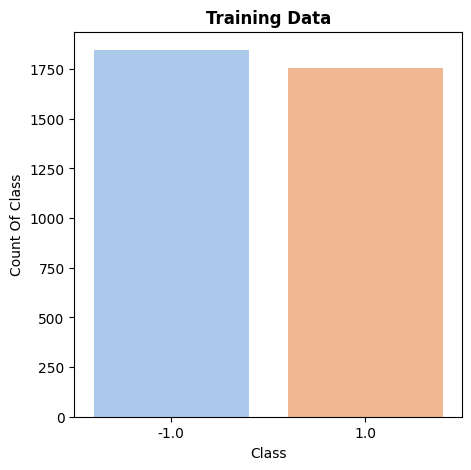

In [13]:
plt.figure(figsize=(5,5))
sns.countplot(x=Train_DF[0], hue=Train_DF[0], legend=False, palette='pastel')
plt.title('Training Data' , fontsize=12, weight='bold')
plt.xlabel('Class', fontsize=10)
plt.ylabel('Count Of Class', fontsize=10)
plt.show()

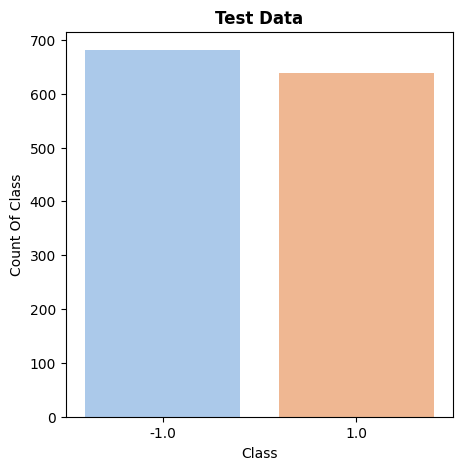

In [14]:
plt.figure(figsize=(5,5))
sns.countplot(x=Test_DF[0], hue=Test_DF[0], legend=False, palette='pastel')
plt.title('Test Data' , fontsize=12, weight='bold')
plt.xlabel('Class', fontsize=10)
plt.ylabel('Count Of Class', fontsize=10)
plt.show()

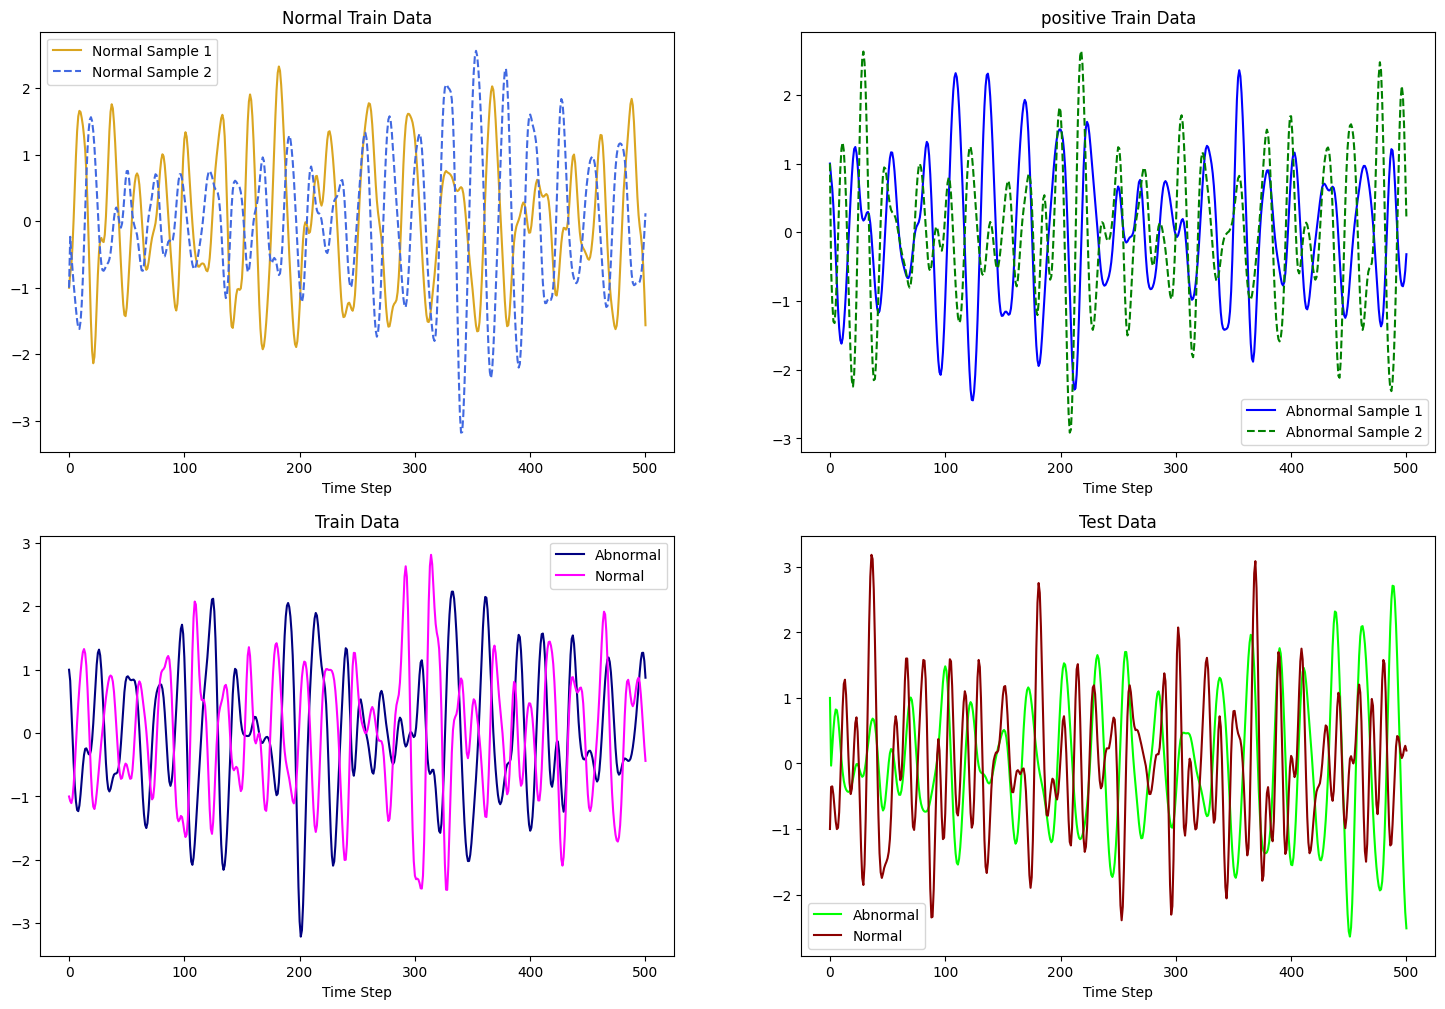

In [15]:
Train_Neg = Train_DF[Train_DF[0] == -1]
Train_Pos = Train_DF[Train_DF[0] == 1]
Test_Neg = Test_DF[Test_DF[0] == -1]
Test_Pos = Test_DF[Test_DF[0] == 1]

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

axes[0,0].plot(Train_Neg.loc[0,:], color='goldenrod')
axes[0,0].plot(Train_Neg.loc[3,:], color='royalblue' , linestyle='--')
axes[0,0].set_title('Normal Train Data')
axes[0,0].set_xlabel('Time Step')
axes[0,0].legend(['Normal Sample 1', 'Normal Sample 2'])

axes[0,1].plot(Train_Pos.loc[1,:], color='blue')
axes[0,1].plot(Train_Pos.loc[5,:], color='green' , linestyle='--')
axes[0,1].set_title('positive Train Data')
axes[0,1].set_xlabel('Time Step')
axes[0,1].legend(['Abnormal Sample 1', 'Abnormal Sample 2'])

axes[1,0].plot(Train_Pos.loc[8,:], color='navy')
axes[1,0].plot(Train_Neg.loc[11,:], color='magenta')
axes[1,0].set_title('Train Data')
axes[1,0].set_xlabel('Time Step')
axes[1,0].legend(['Abnormal', 'Normal'])

axes[1,1].plot(Test_Pos.loc[11,:], color='lime')
axes[1,1].plot(Test_Neg.loc[6,:], color='darkred')
axes[1,1].set_title('Test Data')
axes[1,1].set_xlabel('Time Step')
axes[1,1].legend(['Abnormal', 'Normal'])
plt.show()

# Model Training

### RNN

In [16]:
def create_rnn_model(mlp_neuron_1,R_neuron_1,num_hidden_layer_rnn,lr_adam,dropout_rate,kernel_L2,
                     mlp_neuron_2,activations,R_neuron_2=None,R_neuron_3=None):

    model = Sequential()
    model.add(Input(shape=(x_train.shape[1],1)))
    
    if num_hidden_layer_rnn == 3 and R_neuron_2 is not None and R_neuron_3 is not None:
        
        # First Layer RNN
        model.add(SimpleRNN(units= R_neuron_1, return_sequences=True,
                                           activation=activations, kernel_regularizer=regularizers.l2(kernel_L2)))
        ##model.add(LayerNormalization())
        model.add(Dropout(dropout_rate))

        # Second Layer RNN
        model.add(SimpleRNN(units= R_neuron_2, return_sequences=True,
                                           activation=activations, kernel_regularizer=regularizers.l2(kernel_L2)))
        ##model.add(LayerNormalization())
        model.add(Dropout(dropout_rate))

        # Third Layer RNN
        model.add(SimpleRNN(units= R_neuron_3, return_sequences=True,
                                           activation=activations, kernel_regularizer=regularizers.l2(kernel_L2)))
        ##model.add(LayerNormalization())
        model.add(Dropout(dropout_rate))

    elif num_hidden_layer_rnn == 2 and R_neuron_2 is not None and R_neuron_3 is None:

        # First Layer RNN
        model.add(SimpleRNN(units= R_neuron_1, return_sequences=True,
                                           activation=activations, kernel_regularizer=regularizers.l2(kernel_L2)))
        ##model.add(LayerNormalization())
        model.add(Dropout(dropout_rate))
        
        # Second Layer RNN
        model.add(SimpleRNN(units= R_neuron_2, return_sequences=True,
                                           activation=activations, kernel_regularizer=regularizers.l2(kernel_L2)))
        ##model.add(LayerNormalization())
        model.add(Dropout(dropout_rate))

    elif num_hidden_layer_rnn == 1 and R_neuron_1 is not None:
        model.add(SimpleRNN(units= R_neuron_1, return_sequences=True,
                                           activation=activations, kernel_regularizer=regularizers.l2(kernel_L2)))
        ##model.add(LayerNormalization())
        model.add(Dropout(dropout_rate))
    
    model.add(GlobalAveragePooling1D())

    model.add(Dense(units=mlp_neuron_1, use_bias=False ,activation=None))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(dropout_rate))

    model.add(Dense(units=mlp_neuron_2,activation=None))
    model.add(ReLU())
    model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=lr_adam), loss='binary_crossentropy', metrics=['accuracy'])

    return model

RNN_Model = KerasClassifier(model=create_rnn_model, random_state = 50, verbose=0)

tss_cv = TimeSeriesSplit (n_splits=5)
es = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-4)

In [17]:
param_grid_RNN =[ 
    {
      'model__num_hidden_layer_rnn':[1],
      'model__R_neuron_1': [128],
      'model__mlp_neuron_1': [80],
      'model__mlp_neuron_2': [40],
      'model__activations':['tanh'],
      'model__kernel_L2':[1e-5],
      'model__lr_adam':[0.001],
      'model__dropout_rate': [0.1],
      'epochs':[75],
      'batch_size':[64]
    },

    {
      'model__num_hidden_layer_rnn':[2],
      'model__R_neuron_1': [128],
      'model__R_neuron_2': [64],
      'model__mlp_neuron_1': [80],
      'model__mlp_neuron_2': [40],
      'model__activations':['tanh'],
      'model__kernel_L2':[1e-5],
      'model__lr_adam':[0.001],
      'model__dropout_rate': [0.1],
      'epochs':[75],
      'batch_size':[64]
    },

    {
      'model__num_hidden_layer_rnn':[3],
      'model__R_neuron_1': [128],
      'model__R_neuron_2': [64],
      'model__R_neuron_3': [64],
      'model__mlp_neuron_1': [80],
      'model__mlp_neuron_2': [40],
      'model__activations':['tanh'],
      'model__kernel_L2':[1e-5],
      'model__lr_adam':[0.001],
      'model__dropout_rate': [0.1],
      'epochs':[75],
      'batch_size':[64]
    }

]

In [18]:
Optimized_RNN_Model = GridSearchCV(RNN_Model, param_grid_RNN, cv=tss_cv, verbose=3, return_train_score=True, scoring='f1')
Optimized_RNN_Model.fit(x_train,y_train, callbacks=[es,reduce_lr])

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END batch_size=64, epochs=75, model__R_neuron_1=128, model__activations=tanh, model__dropout_rate=0.1, model__kernel_L2=1e-05, model__lr_adam=0.001, model__mlp_neuron_1=80, model__mlp_neuron_2=40, model__num_hidden_layer_rnn=1;, score=(train=0.710, test=0.749) total time= 2.2min
[CV 2/5] END batch_size=64, epochs=75, model__R_neuron_1=128, model__activations=tanh, model__dropout_rate=0.1, model__kernel_L2=1e-05, model__lr_adam=0.001, model__mlp_neuron_1=80, model__mlp_neuron_2=40, model__num_hidden_layer_rnn=1;, score=(train=0.682, test=0.659) total time= 4.4min
[CV 3/5] END batch_size=64, epochs=75, model__R_neuron_1=128, model__activations=tanh, model__dropout_rate=0.1, model__kernel_L2=1e-05, model__lr_adam=0.001, model__mlp_neuron_1=80, model__mlp_neuron_2=40, model__num_hidden_layer_rnn=1;, score=(train=0.336, test=0.338) total time= 7.0min
[CV 4/5] END batch_size=64, epochs=75, model__R_neuron_1=128, model__acti

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=KerasClassifier(model=<function create_rnn_model at 0x000002CF2EE30E50>, random_state=50, verbose=0),
             param_grid=[{'batch_size': [64], 'epochs': [75],
                          'model__R_neuron_1': [128],
                          'model__activations': ['tanh'],
                          'model__dropout_rate': [0.1],
                          'model__kernel_L2': [1e-05],
                          'mo...
                         {'batch_size': [64], 'epochs': [75],
                          'model__R_neuron_1': [128], 'model__R_neuron_2': [64],
                          'model__R_neuron_3': [64],
                          'model__activations': ['tanh'],
                          'model__dropout_rate': [0.1],
                          'model__kernel_L2': [1e-05],
                          'model__lr_adam': [0.001],
                          'model__mlp_neuron_1': [80],
                          'model__mlp_neuron_2': [40],
                          'model__num_hidden_layer_rnn': [3]}],
             return_train_score=True, scoring='f1', verbose=3)

In [19]:
RNN_results = pd.DataFrame(Optimized_RNN_Model.cv_results_)
Best_Val_Score_RNN = Optimized_RNN_Model.best_score_
print(Best_Val_Score_RNN)
Best_Params_RNN = Optimized_RNN_Model.best_params_
print(Best_Params_RNN)


0.7433883731016249
{'batch_size': 64, 'epochs': 75, 'model__R_neuron_1': 128, 'model__R_neuron_2': 64, 'model__activations': 'tanh', 'model__dropout_rate': 0.1, 'model__kernel_L2': 1e-05, 'model__lr_adam': 0.001, 'model__mlp_neuron_1': 80, 'model__mlp_neuron_2': 40, 'model__num_hidden_layer_rnn': 2}


RNN f1-score:  0.0
LSTM Accuracy-score:  0.5159090909090909


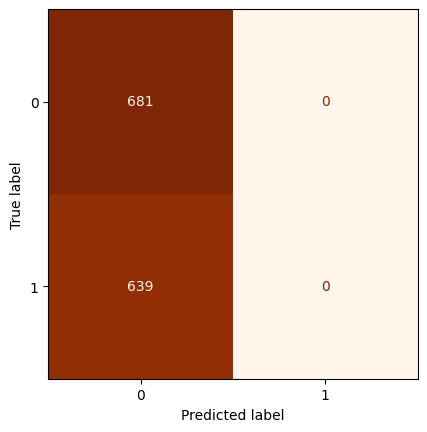

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_30 (SimpleRNN)   (None, 500, 128)          16640     
                                                                 
 dropout_60 (Dropout)        (None, 500, 128)          0         
                                                                 
 simple_rnn_31 (SimpleRNN)   (None, 500, 64)           12352     
                                                                 
 dropout_61 (Dropout)        (None, 500, 64)           0         
                                                                 
 global_average_pooling1d_15  (None, 64)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_45 (Dense)            (None, 80)                5120      
                                                     

In [20]:
Best_Estimator_RNN = Optimized_RNN_Model.best_estimator_

F1_Test_Score_RNN = f1_score(y_test,Best_Estimator_RNN.predict(x_test))
Accuracy_Test_Score_RNN = accuracy_score(y_test,Best_Estimator_RNN.predict(x_test))
Confusion_Matrix_RNN = confusion_matrix(y_test,Best_Estimator_RNN.predict(x_test))

print('RNN f1-score: ', F1_Test_Score_RNN)
print('LSTM Accuracy-score: ', Accuracy_Test_Score_RNN)

display_CM = ConfusionMatrixDisplay(Confusion_Matrix_RNN)
display_CM.plot(cmap=plt.cm.Oranges,colorbar=False)
plt.show()

print(Best_Estimator_RNN.model_.summary())

### LSTM

In [ ]:
def create_lstm_model(mlp_neuron_1,lstm_neuron_1,num_hidden_layer_lstm,lr_adam,dropout_rate,
                     mlp_neuron_2,kernel_L2,lstm_neuron_2=None,lstm_neuron_3=None):

    model = Sequential()
    model.add(Input(shape=(x_train.shape[1],1)))
    
    if num_hidden_layer_lstm == 3 and lstm_neuron_2 is not None and lstm_neuron_3 is not None:

        # First Layer LSTM
        model.add(LSTM(units= lstm_neuron_1, return_sequences=True, kernel_regularizer=regularizers.l2(kernel_L2)))
        ##model.add(LayerNormalization())
        model.add(Dropout(dropout_rate))

        # Second Layer LSTM
        model.add(LSTM(units= lstm_neuron_2, return_sequences=True, kernel_regularizer=regularizers.l2(kernel_L2)))
        ##model.add(LayerNormalization())
        model.add(Dropout(dropout_rate))

        # Third Layer LSTM
        model.add(LSTM(units= lstm_neuron_3, return_sequences=True, kernel_regularizer=regularizers.l2(kernel_L2)))
        ##model.add(LayerNormalization())
        model.add(Dropout(dropout_rate))

    elif num_hidden_layer_lstm == 2 and lstm_neuron_2 is not None and lstm_neuron_3 is None:

        # First Layer LSTM
        model.add(LSTM(units= lstm_neuron_1, return_sequences=True, kernel_regularizer=regularizers.l2(kernel_L2)))
        ##model.add(LayerNormalization())
        model.add(Dropout(dropout_rate))
        
        # Second Layer LSTM
        model.add(LSTM(units= lstm_neuron_2, return_sequences=True, kernel_regularizer=regularizers.l2(kernel_L2)))
        ##model.add(LayerNormalization())
        model.add(Dropout(dropout_rate))

    else:
        
        model.add(LSTM(units= lstm_neuron_1, return_sequences=True, kernel_regularizer=regularizers.l2(kernel_L2)))
        ##model.add(LayerNormalization())
        model.add(Dropout(dropout_rate))

    model.add(GlobalAveragePooling1D())
    
    model.add(Dense(units=mlp_neuron_1, use_bias=False, kernel_regularizer=regularizers.l2(kernel_L2)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(dropout_rate))

    model.add(Dense(units=mlp_neuron_2, kernel_regularizer=regularizers.l2(kernel_L2)))
    model.add(ReLU())
    model.add(Dropout(dropout_rate))


    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=lr_adam), loss='binary_crossentropy', metrics=['accuracy'])

    return model

LSTM_Model = KerasClassifier(model=create_lstm_model, random_state = 50, verbose=0)

tss_cv = TimeSeriesSplit (n_splits=5)
es = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-4)

In [63]:
param_grid_LSTM =[ 
    {
      'model__num_hidden_layer_lstm':[1],
      'model__lstm_neuron_1': [64],
      'model__mlp_neuron_1': [80],
      'model__mlp_neuron_2': [40],
      'model__kernel_L2':[1e-5],
      'model__lr_adam':[0.001],
      'model__dropout_rate': [0.1],
      'epochs':[75],
      'batch_size':[64]
    },

    {
      'model__num_hidden_layer_lstm':[2],
      'model__lstm_neuron_1': [128],
      'model__lstm_neuron_2': [64],
      'model__mlp_neuron_1': [80],
      'model__mlp_neuron_2': [40],
      'model__kernel_L2':[1e-5],
      'model__lr_adam':[0.001],
      'model__dropout_rate': [0.1],
      'epochs':[75],
      'batch_size':[64]
    },

    {
      'model__num_hidden_layer_lstm':[3],
      'model__lstm_neuron_1': [128],
      'model__lstm_neuron_2': [64],
      'model__lstm_neuron_3': [64],
      'model__mlp_neuron_1': [80],
      'model__mlp_neuron_2': [40],
      'model__kernel_L2':[1e-5],
      'model__lr_adam':[0.001],
      'model__dropout_rate': [0.1],
      'epochs':[75],
      'batch_size':[64]
    }
]

In [64]:
Optimized_LSTM_Model = GridSearchCV(LSTM_Model, param_grid_LSTM, cv=tss_cv, verbose=3, return_train_score=True, scoring='f1')
Optimized_LSTM_Model.fit(x_train,y_train, callbacks=[es,reduce_lr])

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END batch_size=64, epochs=75, model__dropout_rate=0.1, model__kernel_L2=1e-05, model__lr_adam=0.001, model__lstm_neuron_1=64, model__mlp_neuron_1=80, model__mlp_neuron_2=40, model__num_hidden_layer_lstm=1;, score=(train=0.918, test=0.921) total time=  36.4s
[CV 2/5] END batch_size=64, epochs=75, model__dropout_rate=0.1, model__kernel_L2=1e-05, model__lr_adam=0.001, model__lstm_neuron_1=64, model__mlp_neuron_1=80, model__mlp_neuron_2=40, model__num_hidden_layer_lstm=1;, score=(train=0.959, test=0.913) total time= 1.1min
[CV 3/5] END batch_size=64, epochs=75, model__dropout_rate=0.1, model__kernel_L2=1e-05, model__lr_adam=0.001, model__lstm_neuron_1=64, model__mlp_neuron_1=80, model__mlp_neuron_2=40, model__num_hidden_layer_lstm=1;, score=(train=0.961, test=0.946) total time= 1.7min
[CV 4/5] END batch_size=64, epochs=75, model__dropout_rate=0.1, model__kernel_L2=1e-05, model__lr_adam=0.001, model__lstm_neuron_1=64, mode

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=KerasClassifier(model=<function create_lstm_model at 0x000001CCD60BE5F0>, random_state=50, verbose=0),
             param_grid=[{'batch_size': [64], 'epochs': [75],
                          'model__dropout_rate': [0.1],
                          'model__kernel_L2': [1e-05],
                          'model__lr_adam': [0.001],
                          'model__lstm_neuron_1': [64],
                          'mode...
                          'model__num_hidden_layer_lstm': [2]},
                         {'batch_size': [64], 'epochs': [75],
                          'model__dropout_rate': [0.1],
                          'model__kernel_L2': [1e-05],
                          'model__lr_adam': [0.001],
                          'model__lstm_neuron_1': [128],
                          'model__lstm_neuron_2': [64],
                          'model__lstm_neuron_3': [64],
                          'model__mlp_neuron_1': [80],
                          'model__mlp_neuron_2': [40],
                          'model__num_hidden_layer_lstm': [3]}],
             return_train_score=True, scoring='f1', verbose=3)

In [65]:
LSTM_results = pd.DataFrame(Optimized_LSTM_Model.cv_results_)
Best_Val_Score_LSTM = Optimized_LSTM_Model.best_score_
print(Best_Val_Score_LSTM)
Best_Params_LSTM = Optimized_LSTM_Model.best_params_
print(Best_Params_LSTM)

0.9221121845768387
{'batch_size': 64, 'epochs': 75, 'model__dropout_rate': 0.1, 'model__kernel_L2': 1e-05, 'model__lr_adam': 0.001, 'model__lstm_neuron_1': 64, 'model__mlp_neuron_1': 80, 'model__mlp_neuron_2': 40, 'model__num_hidden_layer_lstm': 1}


LSTM f1-score:  0.9254612546125461
LSTM Accuracy-score:  0.9234848484848485


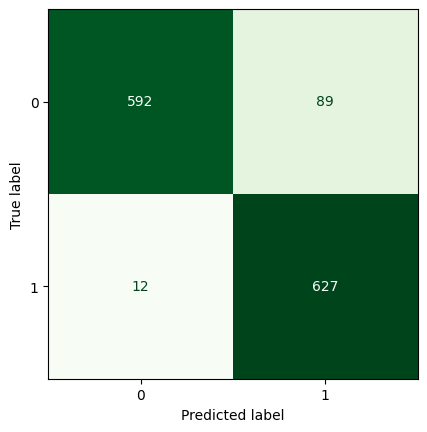

Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_152 (LSTM)             (None, 500, 64)           16896     
                                                                 
 dropout_192 (Dropout)       (None, 500, 64)           0         
                                                                 
 global_average_pooling1d_59  (None, 64)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_177 (Dense)           (None, 80)                5120      
                                                                 
 batch_normalization_59 (Bat  (None, 80)               320       
 chNormalization)                                                
                                                                 
 re_lu_196 (ReLU)            (None, 80)              

In [66]:
Best_Estimator_LSTM = Optimized_LSTM_Model.best_estimator_

F1_Test_Score_LSTM = f1_score(y_test,Best_Estimator_LSTM.predict(x_test))
Accuracy_Test_Score_LSTM = accuracy_score(y_test,Best_Estimator_LSTM.predict(x_test))
Confusion_Matrix_LSTM = confusion_matrix(y_test,Best_Estimator_LSTM.predict(x_test))

print('LSTM f1-score: ', F1_Test_Score_LSTM)
print('LSTM Accuracy-score: ', Accuracy_Test_Score_LSTM)

display_CM = ConfusionMatrixDisplay(Confusion_Matrix_LSTM)
display_CM.plot(cmap=plt.cm.Greens,colorbar=False)
plt.show()

print(Best_Estimator_LSTM.model_.summary())

### Con 1D

In [ ]:
def create_con1_model(mlp_neuron_1,Conv1D_neuron_1,num_hidden_layer_conv1D,dropout_rate,kernel_L2,lr_adam,
                     mlp_neuron_2,kernel_size1,kernel_size2=None,kernel_size3=None,Conv1D_neuron_2=None,Conv1D_neuron_3=None):

    model = Sequential()
    model.add(Input(shape=(x_train.shape[1],1)))

    if num_hidden_layer_conv1D == 3 and Conv1D_neuron_2 is not None and Conv1D_neuron_3 is not None:
        # First Layer Conv1D
        model.add(Conv1D(filters=Conv1D_neuron_1, kernel_size=kernel_size1, padding='same', kernel_regularizer=regularizers.l2(kernel_L2)))
        ##model.add(BatchNormalization())
        model.add(ReLU())
        model.add(Dropout(dropout_rate))

        # Second Layer Conv1D
        model.add(Conv1D(filters=Conv1D_neuron_2, kernel_size=kernel_size2, padding='same', kernel_regularizer=regularizers.l2(kernel_L2)))
        ##model.add(BatchNormalization())
        model.add(ReLU())
        model.add(Dropout(dropout_rate))

        # Third Layer Conv1D
        model.add(Conv1D(filters=Conv1D_neuron_3, kernel_size=kernel_size3, padding='same', kernel_regularizer=regularizers.l2(kernel_L2)))
        ##model.add(BatchNormalization())
        model.add(ReLU())
        model.add(Dropout(dropout_rate))

    elif num_hidden_layer_conv1D == 2 and Conv1D_neuron_2 is not None and Conv1D_neuron_3 is None:
        
        # First Layer Conv1D
        model.add(Conv1D(filters=Conv1D_neuron_1, kernel_size=kernel_size1, padding='same', kernel_regularizer=regularizers.l2(kernel_L2)))
        ##model.add(BatchNormalization())
        model.add(ReLU())
        model.add(Dropout(dropout_rate))

        # Second Layer Conv1D
        model.add(Conv1D(filters=Conv1D_neuron_2, kernel_size=kernel_size2, padding='same', kernel_regularizer=regularizers.l2(kernel_L2)))
        ##model.add(BatchNormalization())
        model.add(ReLU())
        model.add(Dropout(dropout_rate))

    else:
        model.add(Conv1D(filters=Conv1D_neuron_1, kernel_size=kernel_size1, padding='same', kernel_regularizer=regularizers.l2(kernel_L2)))
        ##model.add(BatchNormalization())
        model.add(ReLU())
        model.add(Dropout(dropout_rate))
    
    
    model.add(GlobalAveragePooling1D())

    model.add(Dense(units=mlp_neuron_1, use_bias=False, kernel_regularizer=regularizers.l2(kernel_L2)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(units=mlp_neuron_2, kernel_regularizer=regularizers.l2(kernel_L2)))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=lr_adam), loss='binary_crossentropy', metrics=['accuracy'])

    return model

Con1_Model = KerasClassifier(model=create_con1_model, random_state = 50, verbose=0)

tss_cv = TimeSeriesSplit (n_splits=5)
es = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-4)

In [ ]:
param_grid_Con1 =[ 
    {
      'model__num_hidden_layer_conv1D':[1],
      'model__Conv1D_neuron_1': [128],
      'model__kernel_size1': [5],
      'model__mlp_neuron_1': [80],
      'model__mlp_neuron_2': [40],
      'model__kernel_L2': [1e-5],
      'model__lr_adam':[0.001],
      'model__dropout_rate': [0.1],
      'epochs':[75],
      'batch_size':[64]
    },

    {
      'model__num_hidden_layer_conv1D':[2],
      'model__Conv1D_neuron_1': [128],
      'model__Conv1D_neuron_2': [64],
      'model__kernel_size1': [5],
      'model__kernel_size2': [5],
      'model__mlp_neuron_1': [80],
      'model__mlp_neuron_2': [40],
      'model__kernel_L2': [1e-5],
      'model__lr_adam':[0.001],
      'model__dropout_rate': [0.1],
      'epochs':[75],
      'batch_size':[64]
    },

    {
      'model__num_hidden_layer_conv1D':[3],
      'model__Conv1D_neuron_1': [128],
      'model__Conv1D_neuron_2': [64],
      'model__Conv1D_neuron_3': [64],
      'model__kernel_size1': [5],
      'model__kernel_size2': [5],
      'model__kernel_size3': [3],
      'model__mlp_neuron_1': [80],
      'model__mlp_neuron_2': [40],
      'model__kernel_L2': [1e-5],
      'model__lr_adam':[0.001],
      'model__dropout_rate': [0.1],
      'epochs':[75],
      'batch_size':[64]
    }
]

In [69]:
Optimized_Con1_Model = GridSearchCV(Con1_Model, param_grid_Con1, cv=tss_cv, verbose=3, return_train_score=True, scoring='f1')
Optimized_Con1_Model.fit(x_train,y_train, callbacks=[es,reduce_lr])

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END batch_size=64, epochs=75, model__Conv1D_neuron_1=128, model__dropout_rate=0.1, model__kernel_L2=1e-05, model__kernel_size1=5, model__lr_adam=0.001, model__mlp_neuron_1=80, model__mlp_neuron_2=40, model__num_hidden_layer_conv1D=1;, score=(train=0.804, test=0.793) total time=   8.6s
[CV 2/5] END batch_size=64, epochs=75, model__Conv1D_neuron_1=128, model__dropout_rate=0.1, model__kernel_L2=1e-05, model__kernel_size1=5, model__lr_adam=0.001, model__mlp_neuron_1=80, model__mlp_neuron_2=40, model__num_hidden_layer_conv1D=1;, score=(train=0.151, test=0.103) total time=  15.5s
[CV 3/5] END batch_size=64, epochs=75, model__Conv1D_neuron_1=128, model__dropout_rate=0.1, model__kernel_L2=1e-05, model__kernel_size1=5, model__lr_adam=0.001, model__mlp_neuron_1=80, model__mlp_neuron_2=40, model__num_hidden_layer_conv1D=1;, score=(train=0.734, test=0.755) total time=  23.9s
[CV 4/5] END batch_size=64, epochs=75, model__Conv1D_ne

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=KerasClassifier(model=<function create_con1_model at 0x000001CCD112E4D0>, random_state=50, verbose=0),
             param_grid=[{'batch_size': [64], 'epochs': [75],
                          'model__Conv1D_neuron_1': [128],
                          'model__dropout_rate': [0.1],
                          'model__kernel_L2': [1e-05],
                          'model__kernel_size1': [5], '...
                          'model__Conv1D_neuron_2': [64],
                          'model__Conv1D_neuron_3': [64],
                          'model__dropout_rate': [0.1],
                          'model__kernel_L2': [1e-05],
                          'model__kernel_size1': [5],
                          'model__kernel_size2': [5],
                          'model__kernel_size3': [3], 'model__lr_adam': [0.001],
                          'model__mlp_neuron_1': [80],
                          'model__mlp_neuron_2': [40],
                          'model__num_hidden_layer_conv1D': [3]}],
             return_train_score=True, scoring='f1', verbose=3)

In [70]:
Con1_results = pd.DataFrame(Optimized_Con1_Model.cv_results_)
Best_Val_Score_Con1 = Optimized_Con1_Model.best_score_
print(Best_Val_Score_Con1)
Best_Params_Con1 = Optimized_Con1_Model.best_params_
print(Best_Params_Con1)

0.8864725384560748
{'batch_size': 64, 'epochs': 75, 'model__Conv1D_neuron_1': 128, 'model__Conv1D_neuron_2': 64, 'model__Conv1D_neuron_3': 64, 'model__dropout_rate': 0.1, 'model__kernel_L2': 1e-05, 'model__kernel_size1': 5, 'model__kernel_size2': 5, 'model__kernel_size3': 3, 'model__lr_adam': 0.001, 'model__mlp_neuron_1': 80, 'model__mlp_neuron_2': 40, 'model__num_hidden_layer_conv1D': 3}


Con1 f1-score:  0.9120879120879121
Con1 Accuracy-score:  0.9151515151515152


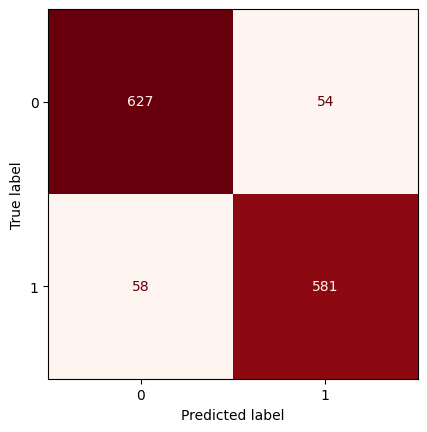

Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_108 (Conv1D)         (None, 500, 128)          768       
                                                                 
 re_lu_228 (ReLU)            (None, 500, 128)          0         
                                                                 
 dropout_255 (Dropout)       (None, 500, 128)          0         
                                                                 
 conv1d_109 (Conv1D)         (None, 500, 64)           41024     
                                                                 
 re_lu_229 (ReLU)            (None, 500, 64)           0         
                                                                 
 dropout_256 (Dropout)       (None, 500, 64)           0         
                                                                 
 conv1d_110 (Conv1D)         (None, 500, 64)         

In [71]:
Best_Estimator_Con1 = Optimized_Con1_Model.best_estimator_

F1_Test_Score_Con1 = f1_score(y_test,Best_Estimator_Con1.predict(x_test))
Accuracy_Test_Score_Con1 = accuracy_score(y_test,Best_Estimator_Con1.predict(x_test))
Confusion_Matrix_Con1 = confusion_matrix(y_test,Best_Estimator_Con1.predict(x_test))

print('Con1 f1-score: ', F1_Test_Score_Con1)
print('Con1 Accuracy-score: ', Accuracy_Test_Score_Con1)

display_CM = ConfusionMatrixDisplay(Confusion_Matrix_Con1)
display_CM.plot(cmap=plt.cm.Reds,colorbar=False)
plt.show()

print(Best_Estimator_Con1.model_.summary())

### LSTM Conv1D

In [85]:
def create_con1_lstm_model(Conv1D_neuron_1,Conv1D_neuron_2,Conv1D_neuron_3,kernel_size1,kernel_size2,kernel_size3,lstm_neuron_1,
                           mlp_neuron_1,mlp_neuron_2,dropout_rate,kernel_L2,lr_adam):

    model = Sequential()
    model.add(Input(shape=(x_train.shape[1],1)))
    
    model.add(Conv1D(filters=Conv1D_neuron_1, kernel_size=kernel_size1, padding='same', kernel_regularizer=regularizers.l2(kernel_L2)))
    ##model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(dropout_rate))

    model.add(Conv1D(filters=Conv1D_neuron_2, kernel_size=kernel_size2, padding='same', kernel_regularizer=regularizers.l2(kernel_L2)))
    ##model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(dropout_rate))

    model.add(Conv1D(filters=Conv1D_neuron_3, kernel_size=kernel_size3, padding='same', kernel_regularizer=regularizers.l2(kernel_L2)))
    ##model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(dropout_rate))

    model.add(LSTM(lstm_neuron_1, return_sequences=True, kernel_regularizer=regularizers.l2(kernel_L2)))
    ##model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    #model.add(LSTM(lstm_neuron_2, return_sequences=True, kernel_regularizer=regularizers.l2(kernel_L2)))
    ##model.add(BatchNormalization())
    #model.add(Dropout(dropout_rate))
    
    #model.add(LSTM(lstm_neuron_3, return_sequences=True))
    ##model.add(BatchNormalization())
    #model.add(Dropout(dropout_rate))

    model.add(GlobalAveragePooling1D())
    
    model.add(Dense(mlp_neuron_1, use_bias=False, kernel_regularizer=regularizers.l2(kernel_L2)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(mlp_neuron_2, kernel_regularizer=regularizers.l2(kernel_L2)))
    ##model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=lr_adam), loss='binary_crossentropy', metrics=['accuracy'])

    return model

Con1_LSTM_Model = KerasClassifier(model=create_con1_lstm_model, random_state = 50, verbose=0)
tss_cv = TimeSeriesSplit (n_splits=5)
es = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-4)

In [91]:
param_grid_Con1_LSTM =[ 
    {
      'model__Conv1D_neuron_1':[128],
      'model__Conv1D_neuron_2':[64],
      'model__Conv1D_neuron_3':[64],
      'model__kernel_size1':[5],
      'model__kernel_size2':[5],
      'model__kernel_size3':[3],
      'model__lstm_neuron_1': [64],
      #'model__lstm_neuron_2': [64],
      #'model__lstm_neuron_3': [64],
      'model__mlp_neuron_1': [80],
      'model__mlp_neuron_2':[40],
      'model__kernel_L2': [0,1e-5],
      'model__lr_adam':[0.001],
      'model__dropout_rate':[0,0.1],
      'epochs':[75],
      'batch_size':[64]
    }
]

In [92]:
Optimized_Con1_LSTM_Model = GridSearchCV(Con1_LSTM_Model, param_grid_Con1_LSTM, cv=tss_cv, verbose=3, return_train_score=True, scoring='f1')
Optimized_Con1_LSTM_Model.fit(x_train,y_train,callbacks=[es,reduce_lr])

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END batch_size=64, epochs=75, model__Conv1D_neuron_1=128, model__Conv1D_neuron_2=64, model__Conv1D_neuron_3=64, model__dropout_rate=0, model__kernel_L2=0, model__kernel_size1=5, model__kernel_size2=5, model__kernel_size3=3, model__lr_adam=0.001, model__lstm_neuron_1=64, model__mlp_neuron_1=80, model__mlp_neuron_2=40;, score=(train=0.993, test=0.917) total time=  46.3s
[CV 2/5] END batch_size=64, epochs=75, model__Conv1D_neuron_1=128, model__Conv1D_neuron_2=64, model__Conv1D_neuron_3=64, model__dropout_rate=0, model__kernel_L2=0, model__kernel_size1=5, model__kernel_size2=5, model__kernel_size3=3, model__lr_adam=0.001, model__lstm_neuron_1=64, model__mlp_neuron_1=80, model__mlp_neuron_2=40;, score=(train=0.974, test=0.913) total time= 1.4min
[CV 3/5] END batch_size=64, epochs=75, model__Conv1D_neuron_1=128, model__Conv1D_neuron_2=64, model__Conv1D_neuron_3=64, model__dropout_rate=0, model__kernel_L2=0, model__kernel_si

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=KerasClassifier(model=<function create_con1_lstm_model at 0x000001CCD3CC5D80>, random_state=50, verbose=0),
             param_grid=[{'batch_size': [64], 'epochs': [75],
                          'model__Conv1D_neuron_1': [128],
                          'model__Conv1D_neuron_2': [64],
                          'model__Conv1D_neuron_3': [64],
                          'model__dropout_rate': [0, 0.1],
                          'model__kernel_L2': [0, 1e-05],
                          'model__kernel_size1': [5],
                          'model__kernel_size2': [5],
                          'model__kernel_size3': [3], 'model__lr_adam': [0.001],
                          'model__lstm_neuron_1': [64],
                          'model__mlp_neuron_1': [80],
                          'model__mlp_neuron_2': [40]}],
             return_train_score=True, scoring='f1', verbose=3)

In [93]:
Con1_LSTM_results = pd.DataFrame(Optimized_Con1_LSTM_Model.cv_results_)
Best_Val_Score_Con1_LSTM = Optimized_Con1_LSTM_Model.best_score_
print(Best_Val_Score_Con1_LSTM)
Best_Params_Con1_LSTM = Optimized_Con1_LSTM_Model.best_params_
print(Best_Params_Con1_LSTM)

0.9187117038831033
{'batch_size': 64, 'epochs': 75, 'model__Conv1D_neuron_1': 128, 'model__Conv1D_neuron_2': 64, 'model__Conv1D_neuron_3': 64, 'model__dropout_rate': 0.1, 'model__kernel_L2': 0, 'model__kernel_size1': 5, 'model__kernel_size2': 5, 'model__kernel_size3': 3, 'model__lr_adam': 0.001, 'model__lstm_neuron_1': 64, 'model__mlp_neuron_1': 80, 'model__mlp_neuron_2': 40}


Con1-LSTM f1-score: 0.9452 
Con1-LSTM accuracy-score: 0.9462
Model: "sequential_117"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_230 (Conv1D)         (None, 500, 128)          768       
                                                                 
 re_lu_432 (ReLU)            (None, 500, 128)          0         
                                                                 
 dropout_490 (Dropout)       (None, 500, 128)          0         
                                                                 
 conv1d_231 (Conv1D)         (None, 500, 64)           41024     
                                                                 
 re_lu_433 (ReLU)            (None, 500, 64)           0         
                                                                 
 dropout_491 (Dropout)       (None, 500, 64)           0         
                                                         

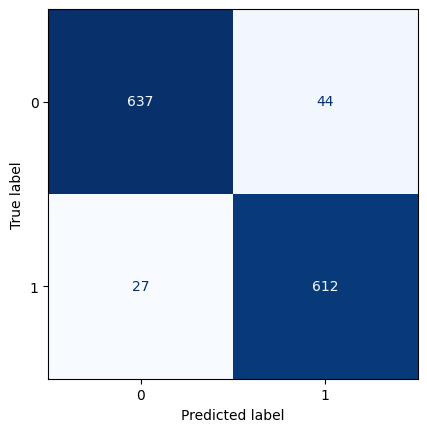

In [94]:
Best_Estimator_Con1_LSTM = Optimized_Con1_LSTM_Model.best_estimator_
F1_Test_Score_Con1_LSTM = f1_score(y_test,Best_Estimator_Con1_LSTM.predict(x_test))
Accuracy_Test_Score_Con1_LSTM = accuracy_score(y_test,Best_Estimator_Con1_LSTM.predict(x_test))
Confusion_Matrix_Con1_LSTM = confusion_matrix(y_test,Best_Estimator_Con1_LSTM.predict(x_test))
print('Con1-LSTM f1-score: %.4f ' % F1_Test_Score_Con1_LSTM)
print('Con1-LSTM accuracy-score: %.4f' % Accuracy_Test_Score_Con1_LSTM)

print(Best_Estimator_Con1_LSTM.model_.summary())

display_CM = ConfusionMatrixDisplay(Confusion_Matrix_Con1_LSTM)
display_CM.plot(cmap=plt.cm.Blues,colorbar=False)
plt.show()